In [1]:
# Import libraries
import pickle
import http.client, urllib.parse
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import fastai.tabular.all as fastai
np.set_printoptions(linewidth=130)
import torch
import json

load_dotenv()
key = os.getenv('API_KEY')

# longLats pickle
def load_pkl():
  longLats = pickle.load(open('./longLat.pkl', 'rb'))
  print(f"longLats loaded. {len(longLats)}")
  return longLats
def dump_pkl(longLats):
    pickle.dump(longLats, open('./longLat.pkl', 'wb'))
    print(f"pickle dumped. {len(longLats)}")
longLats = load_pkl()

# clean up data: area, date, floor, price
def load_csv():
  #return pd.read_csv('./data/Woodlands_June22_May23.csv')
  return pd.read_csv('./data/resale-flat-from-jan-2017.csv')
floor_dict = { f'0{i*3+1} TO 0{i*3+3}' if i < 3 else f'{i*3+1} TO {i*3+3}': i*3+2  for i in range(17)  }
def floor_cleanup(df):
  df['floor'] = df.storey_range.apply(lambda x:float(floor_dict[x]) if isinstance(x,str) else x)
  df.drop(['storey_range'], axis=1, inplace=True)
  return df
date_dict = { f'20{17+i}-0{j+1}' if j < 9 else f'20{17+i}-{j+1}': i*12+j  for i in range(7) for j in range(12)  }
def date_cleanup(df):
  df['date'] = df.month.apply(lambda x:float(date_dict[x]) if isinstance(x,str) else x)
  df.drop(['month'], axis=1, inplace=True)
  return df
def load_and_cleanup():
  df = load_csv()
  df = floor_cleanup(df)
  df = date_cleanup(df)
  return df

df = load_and_cleanup()
df.describe()
date_max = df.date.max()
town = 'Choa_Chu_Kang'
df = df[(df.town==town.replace('_', ' ').upper()) & (df.date > date_max-12)]

from pathlib import Path
file = Path(f'./data/{town}_June22_May23.csv')
df.to_csv(file,index=False)
df


longLats loaded. 4158


,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
128179,CHOA CHU KANG,2 ROOM,535,CHOA CHU KANG ST 51,46.0,Model A,2011,88 years 03 months,305000.0,11.0,65.0
128180,CHOA CHU KANG,2 ROOM,166A,TECK WHYE CRES,47.0,2-room,2015,91 years 09 months,290000.0,11.0,65.0
128181,CHOA CHU KANG,3 ROOM,807A,CHOA CHU KANG AVE 1,67.0,Model A,2017,93 years 11 months,400000.0,11.0,65.0
128182,CHOA CHU KANG,3 ROOM,818A,CHOA CHU KANG AVE 1,67.0,Model A,2017,94 years 04 months,463000.0,17.0,65.0
128183,CHOA CHU KANG,3 ROOM,811B,CHOA CHU KANG AVE 7,68.0,Model A,2017,94 years 06 months,410000.0,17.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
152788,CHOA CHU KANG,EXECUTIVE,758,CHOA CHU KANG NTH 5,152.0,Maisonette,1995,71 years 04 months,795000.0,5.0,76.0
152789,CHOA CHU KANG,EXECUTIVE,561,CHOA CHU KANG NTH 6,147.0,Apartment,1996,71 years 10 months,780000.0,5.0,76.0
152790,CHOA CHU KANG,EXECUTIVE,163,JLN TECK WHYE,143.0,Maisonette,1998,74 years 01 month,785000.0,5.0,76.0
152791,CHOA CHU KANG,EXECUTIVE,134,TECK WHYE LANE,144.0,Apartment,1993,69 years 01 month,740000.0,5.0,76.0


In [2]:
blk_street = df.block + ' ' + df.street_name

longLats = load_pkl()
responses = []
errors = []
count = 0

conn = http.client.HTTPConnection('api.positionstack.com')
for i,add in enumerate(blk_street.unique()):
    params = urllib.parse.urlencode({
        'access_key': key,
        'query': add,
        'region': 'Singapore',
        'limit': 1,
    })
    conn.request('GET', '/v1/forward?{}'.format(params))
    res = conn.getresponse()
    data = res.read()
    dataList = json.loads(data.decode('utf-8'))['data']
    if (len(dataList)==0): 
      print(f"check {add}. No data returned")
      count += 1
      errors.append(add)
      continue
    first_response = dataList[0]
    responses.append(first_response)
    if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
      longLats[f"{add}"] = (first_response['longitude'], first_response['latitude'])
      if (i%10==0): print(f"{i} of {len(blk_street.unique())}")
    else:
      print(f"check {add}. {first_response['label']}. confidence of {first_response['confidence']}")
      count += 1
      errors.append(add)

print(f"{count} errors detected")
dump_pkl(longLats)


longLats loaded. 4158
0 of 424
10 of 424
20 of 424
30 of 424
40 of 424
50 of 424
60 of 424
70 of 424
80 of 424
90 of 424
check 164 JLN TECK WHYE. 67 Jln Tambur, Singapore. confidence of 0.8
100 of 424
110 of 424
120 of 424
check 152 JLN TECK WHYE. 67 Jln Tambur, Singapore. confidence of 0.8
check 151 JLN TECK WHYE. 67 Jln Tambur, Singapore. confidence of 0.8
check 154 JLN TECK WHYE. 67 Jln Tambur, Singapore. confidence of 0.8
130 of 424
140 of 424
check 160 JLN TECK WHYE. 67 Jln Tambur, Singapore. confidence of 0.8
150 of 424
160 of 424
170 of 424
180 of 424
190 of 424
200 of 424
210 of 424
220 of 424
230 of 424
240 of 424
250 of 424
check 163 JLN TECK WHYE. 67 Jln Tambur, Singapore. confidence of 0.8
260 of 424
270 of 424
check 162 JLN TECK WHYE. 67 Jln Tambur, Singapore. confidence of 0.8
290 of 424
300 of 424
check 158 JLN TECK WHYE. 67 Jln Tambur, Singapore. confidence of 0.8
check 159 JLN TECK WHYE. 67 Jln Tambur, Singapore. confidence of 0.8
check 157 JLN TECK WHYE. 67 Jln Tambur

In [6]:
df = df[df.street_name!='JLN TECK WHYE'].copy()
df

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
128179,CHOA CHU KANG,2 ROOM,535,CHOA CHU KANG ST 51,46.0,Model A,2011,88 years 03 months,305000.0,11.0,65.0
128180,CHOA CHU KANG,2 ROOM,166A,TECK WHYE CRES,47.0,2-room,2015,91 years 09 months,290000.0,11.0,65.0
128181,CHOA CHU KANG,3 ROOM,807A,CHOA CHU KANG AVE 1,67.0,Model A,2017,93 years 11 months,400000.0,11.0,65.0
128182,CHOA CHU KANG,3 ROOM,818A,CHOA CHU KANG AVE 1,67.0,Model A,2017,94 years 04 months,463000.0,17.0,65.0
128183,CHOA CHU KANG,3 ROOM,811B,CHOA CHU KANG AVE 7,68.0,Model A,2017,94 years 06 months,410000.0,17.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
152787,CHOA CHU KANG,EXECUTIVE,759,CHOA CHU KANG NTH 5,145.0,Maisonette,1995,71 years 04 months,785000.0,11.0,76.0
152788,CHOA CHU KANG,EXECUTIVE,758,CHOA CHU KANG NTH 5,152.0,Maisonette,1995,71 years 04 months,795000.0,5.0,76.0
152789,CHOA CHU KANG,EXECUTIVE,561,CHOA CHU KANG NTH 6,147.0,Apartment,1996,71 years 10 months,780000.0,5.0,76.0
152791,CHOA CHU KANG,EXECUTIVE,134,TECK WHYE LANE,144.0,Apartment,1993,69 years 01 month,740000.0,5.0,76.0


In [7]:
file = Path(f'./data/{town}_June22_May23_without_newest.csv')
df.to_csv(file,index=False)
df

,town,flat_type,block,street_name,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,floor,date
128179,CHOA CHU KANG,2 ROOM,535,CHOA CHU KANG ST 51,46.0,Model A,2011,88 years 03 months,305000.0,11.0,65.0
128180,CHOA CHU KANG,2 ROOM,166A,TECK WHYE CRES,47.0,2-room,2015,91 years 09 months,290000.0,11.0,65.0
128181,CHOA CHU KANG,3 ROOM,807A,CHOA CHU KANG AVE 1,67.0,Model A,2017,93 years 11 months,400000.0,11.0,65.0
128182,CHOA CHU KANG,3 ROOM,818A,CHOA CHU KANG AVE 1,67.0,Model A,2017,94 years 04 months,463000.0,17.0,65.0
128183,CHOA CHU KANG,3 ROOM,811B,CHOA CHU KANG AVE 7,68.0,Model A,2017,94 years 06 months,410000.0,17.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...
152787,CHOA CHU KANG,EXECUTIVE,759,CHOA CHU KANG NTH 5,145.0,Maisonette,1995,71 years 04 months,785000.0,11.0,76.0
152788,CHOA CHU KANG,EXECUTIVE,758,CHOA CHU KANG NTH 5,152.0,Maisonette,1995,71 years 04 months,795000.0,5.0,76.0
152789,CHOA CHU KANG,EXECUTIVE,561,CHOA CHU KANG NTH 6,147.0,Apartment,1996,71 years 10 months,780000.0,5.0,76.0
152791,CHOA CHU KANG,EXECUTIVE,134,TECK WHYE LANE,144.0,Apartment,1993,69 years 01 month,740000.0,5.0,76.0


In [8]:
def lat_long(df):
  adds = (df.block + ' ' + df.street_name)
  longLat = adds.apply(lambda x: longLats[x])
  df['long'] = longLat.apply(lambda x: x[0])
  df['lat'] = longLat.apply(lambda x: x[1])
  return df
lat_long(df)
df.describe()

,floor_area_sqm,lease_commence_date,resale_price,floor,date,long,lat
count,1236.000000,1236.000000,1236.000000,1236.00000,1236.000000,1236.000000,1236.000000
mean,107.186893,2002.553398,537048.519417,8.11165,70.305016,103.745461,1.384061
std,19.951476,11.434215,96042.723136,4.71629,3.383218,0.004652,0.010163
min,46.000000,1978.000000,282000.000000,2.00000,65.000000,103.734548,1.372521
25%,93.000000,1994.000000,475000.000000,5.00000,68.000000,103.742373,1.376134
50%,106.000000,1999.000000,525000.000000,8.00000,70.000000,103.745526,1.379944
75%,121.000000,2017.000000,595766.000000,11.00000,73.000000,103.749049,1.393068
max,154.000000,2018.000000,880000.000000,23.00000,76.000000,103.755832,1.404691


SuggestedLRs(valley=0.0012022644514217973, slide=6.309573450380412e-07)

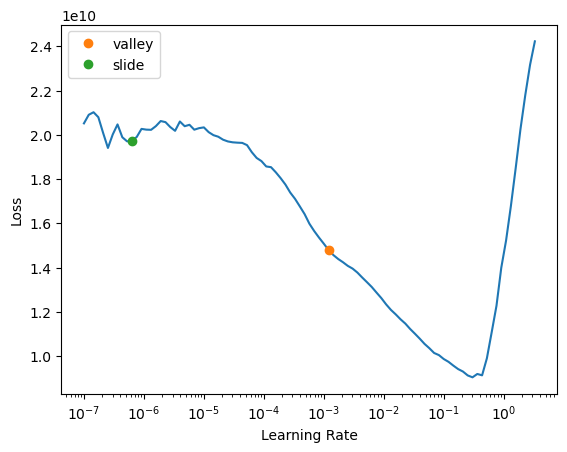

In [9]:
dls = fastai.TabularDataLoaders.from_df(df,procs=[fastai.Normalize],cont_names=["floor", "floor_area_sqm", "lease_commence_date", "date", "lat","long"],y_names=["resale_price"])
#dls.show_batch()
def MSE(yhat,y):
  return torch.mean(torch.square(yhat-y))
def RMSE(yhat,y):
  return torch.sqrt(MSE(yhat,y))
learn = fastai.tabular_learner(dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),loss_func=MSE,metrics=RMSE)
learn.lr_find(suggest_funcs=(fastai.valley,fastai.slide))


In [14]:
learn = fastai.tabular_learner(
  dls,y_range=(df.resale_price.min()*0.95, df.resale_price.max()*1.05),
  loss_func=MSE,metrics=RMSE,
  cbs=[fastai.SaveModelCallback(),fastai.EarlyStoppingCallback(patience=5)]
)
learn.fit_one_cycle(100,5e-2)
learn.validate()


Better model found at epoch 0 with valid_loss value: 28991.490234375.


(#2) [846707712.0,28991.490234375]

In [15]:
# predict prices on map
row = df.drop(['resale_price'], axis=1).iloc[0].copy()
cats = ['floor', 'floor_area_sqm', 'lease_commence_date', 'date']
for cat in cats:
  row[cat] = df[cat].median()
latMin, latMax = df.lat.min(),df.lat.max()
latLeft = latMin - (latMax-latMin)/10
latRight = latMax + (latMax-latMin)/10
longMin, longMax = df.long.min(),df.long.max()
longLeft = longMin - (longMax-longMin)/10
longRight = longMax + (longMax-longMin)/10
n1 = 3*30
n2 = 4*30
longs = np.linspace(longLeft, longRight, n1)
lats = np.linspace(latLeft, latRight, n2)
prices = np.ndarray((n2,n1))
for i,lat in enumerate(lats):
  if i%10==0: print(f"{i} of {n2}") 
  row['lat'] = lat
  for j,long in enumerate(longs):
    row['long'] = long
    with learn.no_bar(), learn.no_logging():
      _, yPred, _ = learn.predict(row)
      prices[i][j] = yPred.item()

0 of 120
10 of 120
20 of 120
30 of 120
40 of 120
50 of 120
60 of 120
70 of 120
80 of 120
90 of 120
100 of 120
110 of 120


In [17]:
import http.client, urllib.parse
import json

mrts = ["Choa Chu Kang MRT", "Yew Tee MRT"]
longLats = load_pkl()

responses = []
for mrt in mrts:
	conn = http.client.HTTPConnection('api.positionstack.com')
	params = urllib.parse.urlencode({
		'access_key': key,
		'query': mrt[:-4] + ' Station',
		'region': 'Singapore',
		'limit': 1,
	})
	conn.request('GET', '/v1/forward?{}'.format(params))
	res = conn.getresponse()
	data = res.read()
	dataList = json.loads(data.decode('utf-8'))['data']
	if (len(dataList)==0): 
		print(f"check {add}. No data returned")
		count += 1
		errors.append(add)
		continue
	first_response = dataList[0]
	responses.append(first_response)
	if (first_response['confidence'] > 0.9) and (first_response['country']=='Singapore'):
		longLats[f"{mrt}"] = (first_response['longitude'], first_response['latitude'])
		print(f"{first_response['label']}, confidence {first_response['confidence']}")
	else:
		print(f"check {mrt}. {first_response['label']}. confidence of {first_response['confidence']}")

dump_pkl(longLats)


longLats loaded. 4728
Choa Chu Kang Station, Singapore, confidence 1
Yew Tee Station, Singapore, confidence 1
pickle dumped. 4730


In [18]:
longLats['Upper Changi MRT']

(103.96138, 1.341393)

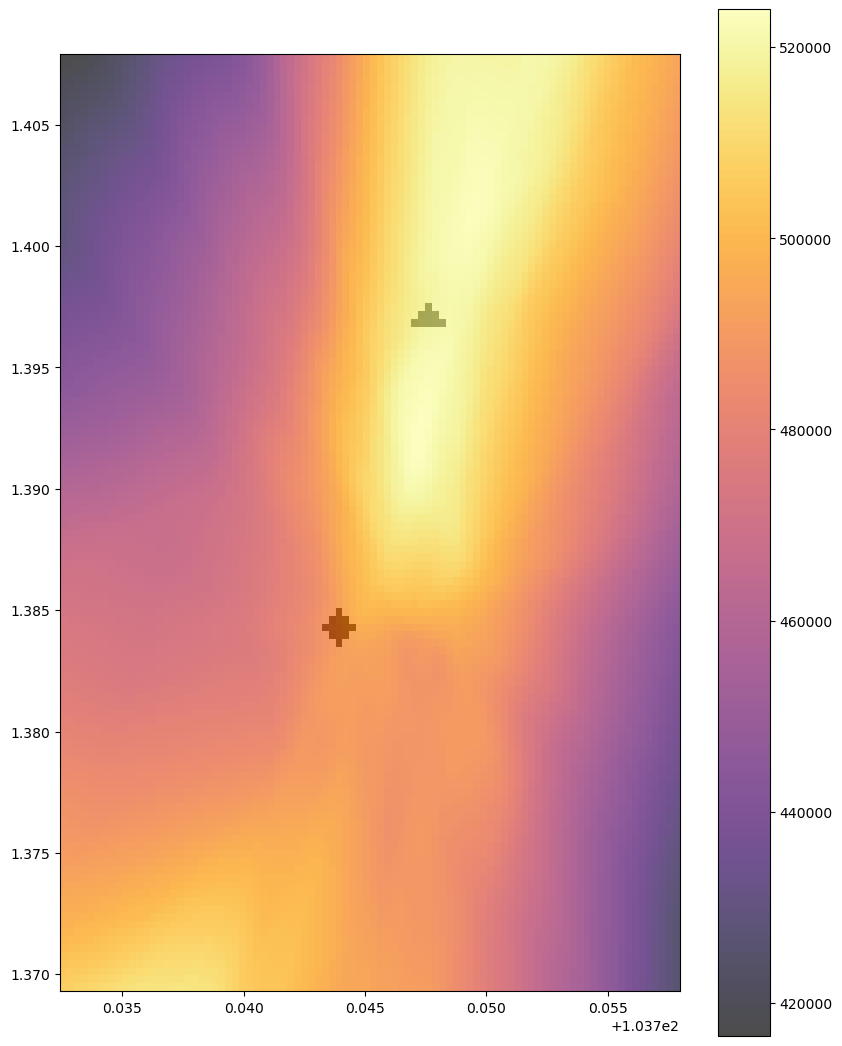

In [18]:
def min_coords(long,lat):
  return (np.abs((longs-long)).argmin(), np.abs(lats-lat).argmin())
def map_left(i,j):
  mrt_map[j-2][i+1]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+2][i+1]=1
def map_sq(i,j):
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+1][i-1]=1
def map_right(i,j):
  mrt_map[j-2][i-1]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+2][i-1]=1
def map_up(i,j):
  mrt_map[j+1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j-1][i-2]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j-1][i+2]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i]=1
def map_down(i,j):
  mrt_map[j-1][i]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j+1][i-2]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+1][i+2]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j+1][i]=1
def map_star(i,j):
  mrt_map[j+1][i]=1
  mrt_map[j+1][i-1]=1
  mrt_map[j+1][i+1]=1
  mrt_map[j-1][i]=1
  mrt_map[j-1][i+1]=1
  mrt_map[j-1][i-1]=1
  mrt_map[j][i]=1
  mrt_map[j][i-1]=1
  mrt_map[j][i+1]=1
  mrt_map[j][i-2]=1
  mrt_map[j][i+2]=1
  mrt_map[j+2][i]=1
  mrt_map[j-2][i]=1
mrt_map = np.zeros((n2,n1))

map_star(*min_coords(*longLats[mrts[0]]))
map_up(*min_coords(*longLats[mrts[1]]))
#map_left(*min_coords(*longLats[mrts[2]]))
#map_right(*min_coords(*longLats[mrts[3]]))
#map_right(*min_coords(*longLats[mrts[4]]))

fig,ax=plt.subplots()
#mrt
#color map
shw2 = ax.imshow(mrt_map, extent=[longLeft, longRight, latLeft, latRight], origin='lower',cmap='Greys',alpha=1.0)
shw = ax.imshow(prices, extent=[longLeft, longRight, latLeft, latRight], origin='lower',alpha=0.7, cmap='inferno')
bar = plt.colorbar(shw)
fig.set_figwidth(10)
fig.set_figheight(10/n1*n2)

plt.show()

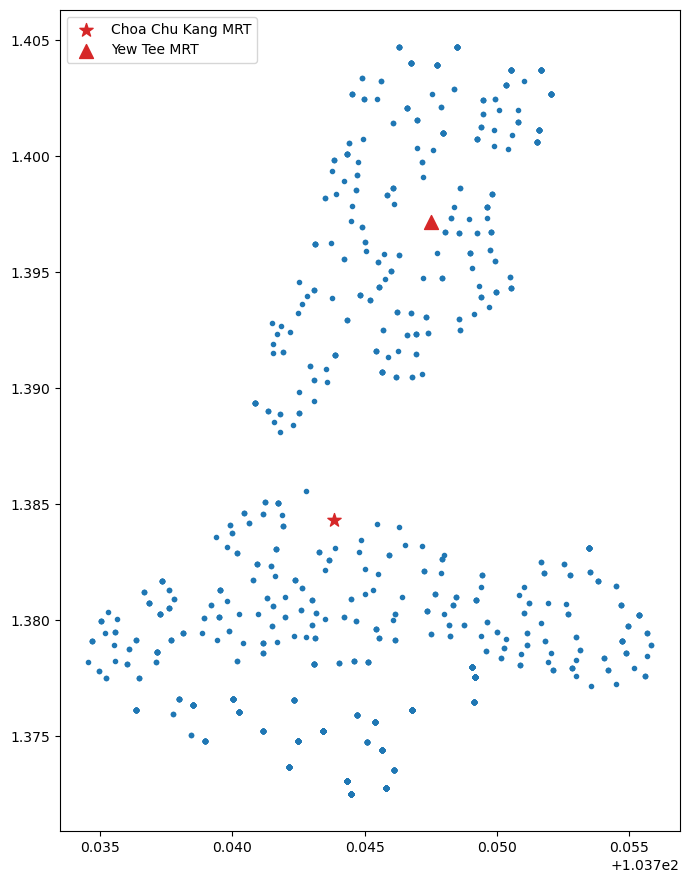

In [19]:
markers = ["*", '^', "<", '>', '>', '^', '^']

fig,ax2=plt.subplots()
ax2.scatter(df.long,df.lat,marker='.')
for i,mrt in enumerate(mrts):
  ax2.scatter([longLats[mrt][0]], [longLats[mrt][1]],marker=markers[i],c='#d62728',label=mrt,s=100)
ax2.legend(loc='upper left')
fig.set_figwidth(8)
fig.set_figheight(8/n1*n2)

plt.show()

for mrt in mrts:
  (i,j) = min_coords(*longLats[mrt])
